In [843]:
from scipy.special import hyp1f1, gamma, factorial
import numpy as np
import matplotlib.pyplot as plt

import numexpr as ne

import PyUltraLight_NBody_D as PyUL

print(PyUL.D_version)

import PyUltraLight_NBody_WX as PyUL

np.set_printoptions(suppress=True)

import math

import time
import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

from scipy.special import gamma

import h5py
from IPython.core.display import clear_output, display

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Integrator Build 2021 03 25


In [844]:
import matplotlib.font_manager as fm
# Collect all the font names available to matplotlib
#font_names = [f.name for f in fm.fontManager.ttflist]
print(font_names)

mpl.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2


Palette = 'magma'
CycPalette = 'Greys'
DivPalette = 'seismic_r'

['DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXSizeFourSym', 'DejaVu Serif Display', 'DejaVu Sans Display', 'cmtt10', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'cmr10', 'cmex10', 'cmb10', 'DejaVu Serif', 'DejaVu Serif', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXGeneral', 'STIXSizeTwoSym', 'STIXSizeOneSym', 'STIXGeneral', 'DejaVu Sans Mono', 'STIXGeneral', 'STIXSizeFiveSym', 'cmmi10', 'cmsy10', 'STIXNonUnicode', 'STIXSizeThreeSym', 'STIXNonUnicode', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Sans', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'cmss10', 'STIXSizeFourSym', 'STIXNonUnicode', 'MathJax_Size4', 'Bitstream Vera Serif', 'MathJax_Typewriter', 'MathJax_Main', 'MathJax_Math', 'MathJax_Fraktur', 'wasy10', 'MathJax_Main', 'MathJax_WinChrome', 'Bitstream Vera Sans Mono', 'DejaVu Sans', 'FontAwesome', 'MathJax_Script', 'Bitstream Vera Sans', 'Bitstream Vera Sans', 'MathJax_Math', 'MathJax_Vector', 'MathJax_Math', 'MathJax_Size1', 'MathJax_WinIE6', 'cmsy10', '

In [823]:
save_path = '2021QuantumWind'  # Set Output Directory

TimeStamp = PyUL.Runs(save_path)
clear_output()
loc = './' + save_path + '/' + TimeStamp
print(loc,'\n')
# Reload Config

NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, embeds, Uniform,Density, density_unit ,a, B, UVel = PyUL.LoadConfig(loc)

# Reload Output

EndNum, data, TMdata, phidata, graddata, phasedata = PyUL.Load_Data(save_path,TimeStamp, save_options,save_number)

NBo = len(particles)

./2021QuantumWind/LongThousand 

ULHelper: Loaded Planar Mass Density Data 

ULHelper: Loaded Test Mass State Data 

ULHelper: Loaded Planar Gravitational Field Data 

ULHelper: Loaded Test Mass Gradient Data 

ULHelper: Loaded Planar ULD Phase Data 

ULHelper: Loaded 161 Data Entries


In [824]:
ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

# Time
durationMyr = ToPhys(ToCode(duration,duration_units,'t'),'Myr','t') * (EndNum-1) / save_number

# Space
lengthKpc = ToPhys(ToCode(length,length_units,'l'),'kpc','l')

# Mass

MassList_MSol = []
MassListSI = []
for TM in particles:
    MassList_MSol.append(CB(TM[0],m_mass_unit,'M_solar_masses','m'))
    MassListSI.append(CB(TM[0],m_mass_unit,'kg','m'))
    
# Density
densitySI = ToPhys(ToCode(Density,density_unit,'d'),'kg/m3','d')

## Misc. Pre-Multipliers

# NBody_State Vector

XPre = ToPhys(1,'kpc','l')
VPre = ToPhys(1,'km/s','v')

XPreSI = ToPhys(1,'m','l')
VPreSI = ToPhys(1,'m/s','v')

IArray = np.arange(len(TMdata[0]))

# Dimensionful NBody State

TMDataS = np.array(TMdata)
TMDataSI = np.array(TMdata)

TMDataS[:,IArray % 6 <= 2] *= XPre
TMDataS[:,IArray % 6 >= 3] *= VPre

TMDataSI[:,IArray % 6 <= 2] *= XPreSI
TMDataSI[:,IArray % 6 >= 3] *= VPreSI


# Rho data

DPre = ToPhys(1,'kg/m3','d')

# Energy
EPre = PyUL.energy_unit

# Field Strength
PPre = PyUL.mass_unit / PyUL.length_unit


print('Unit conversion ready!')


print("==============================================")
print(f"PyULN: Axion Mass Used is {PyUL.axion_E} eV.\n")

print(f"\
1 Mass Unit    = {PyUL.mass_unit:.5g} kg = {PyUL.convert_back(1,'solar_masses','m'):.4g} MSol\n\
1 Length Unit  = {PyUL.length_unit:.5g} m  = {PyUL.convert_back(1,'kpc','l'):.4g} kpc\n\
1 Time Unit    = {PyUL.time_unit:.5g} s  = {PyUL.convert_back(1,'Myr','t')/1000:.4g} Gyr\n\n\
1 Density Unit = {PyUL.mass_unit/PyUL.length_unit**3:.5g} kg/m^3 = {PyUL.mass_unit/PyUL.length_unit**3/PyUL.CritDens} Critical Density\n\
1 Speed Unit   = {PyUL.length_unit/PyUL.time_unit:.5g} m/s\n\
1 Energy Unit  = {EPre:.5g} Joules\n")

Unit conversion ready!
PyULN: Axion Mass Used is 1e-22 eV.

1 Mass Unit    = 4.4304e+36 kg = 2.227e+06 MSol
1 Length Unit  = 1.1838e+21 m  = 38.36 kpc
1 Time Unit    = 2.3694e+18 s  = 75.13 Gyr

1 Density Unit = 2.6705e-27 kg/m^3 = 0.31 Critical Density
1 Speed Unit   = 499.62 m/s
1 Energy Unit  = 1.1059e+42 Joules



In [825]:
TML = PyUL.convert_between(TMDataSI[0,1],'m',length_units,'l') # The fixed Y Position

print(TML)

print(UVel, s_velocity_unit)

12.043451789697686
[0, -10, 0] km/s


In [826]:
# Let's work everything in consistent astrophysical Units!.

Mass = MassListSI[0]

print(f'BH Mass is {Mass:.4g} kg')

speed = 10000 # m/s

lamb = 2*np.pi*PyUL.hbar/(PyUL.axion_mass*speed) # Full Quantum de Broglie

beta = 2*np.pi*(PyUL.G*Mass)/(speed**2*lamb) # Checked

print(f"de Broglie wavelength: {lamb:.5g} m\n\
Dimensionless Beta: {beta:.5g}")


BH Mass is 1.989e+34 kg
de Broglie wavelength: 3.7162e+20 m
Dimensionless Beta: 0.0002243


In [827]:
print(length,length_units)

lambKpc = PyUL.convert_between(lamb,'m',length_units,'l')

print(lambKpc,length_units)

96.34761431758149 kpc
12.043451789697688 kpc


In [828]:
bound = length # Corresponding to the length we got. in User Units

resolA = 500

GridVec = np.linspace(-bound,bound,resolA,endpoint = False)

GridVecR = np.linspace(-bound/2,bound/2,resol,endpoint = False)

GridVecY = np.linspace(-bound/6,bound/6,resolA*2,endpoint = False)

In [829]:
x,y = np.meshgrid(GridVec,GridVec,indexing = 'ij', sparse = True)

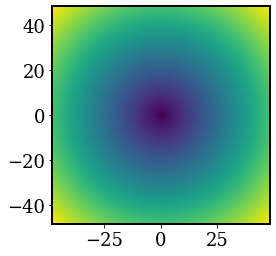

In [830]:
RArray = ne.evaluate('sqrt(x*x+y*y)')

plt.imshow(RArray,extent = (-bound/2,bound/2,-bound/2,bound/2))

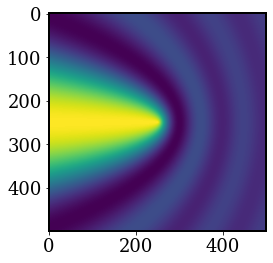

In [831]:
SumLim = 80

a = beta*1j
b = 1

In = 1j*(RArray+y)/lambKpc

HypL = np.complex256(0)

for ii in range(SumLim):
    
    HypL += gamma(a+ii)/gamma(a)*gamma(b)/gamma(b+ii)/gamma(ii+1)*In**ii
    
    
HypL *= np.abs(gamma(1-beta*1j))

HypL *= (np.exp(-1j*2*np.pi*y/lambKpc + np.pi*beta/2))

HypL *= np.conj(HypL)

plt.imshow(HypL.real)

In [625]:
np.max(np.abs(In**196))

8.938689619253782e+306

(-0+0j)


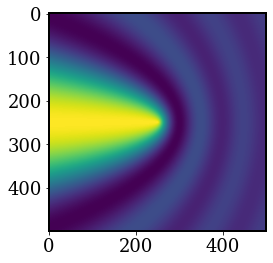

In [832]:
SumLim = 172

a = beta*1j

b = 1

In = 1j*(RArray+y)/lambKpc

Hyp = np.complex256(0)

for ii in range(SumLim):
    Hyp += gamma(a+ii)/gamma(a)/gamma(ii+1)**2*In**ii
    
    if ii == SumLim-1:
        print(gamma(a+ii)/gamma(a)/gamma(ii+1))
    
Hyp *= np.abs(gamma(1-beta*1j))

Hyp *= (np.exp(-1j*2*np.pi*y/lambKpc + np.pi*beta/2))

Hyp *=  np.conj(Hyp)

plt.imshow(Hyp.real)

In [485]:
factorial(170, exact = False)

7.257415615308e+306

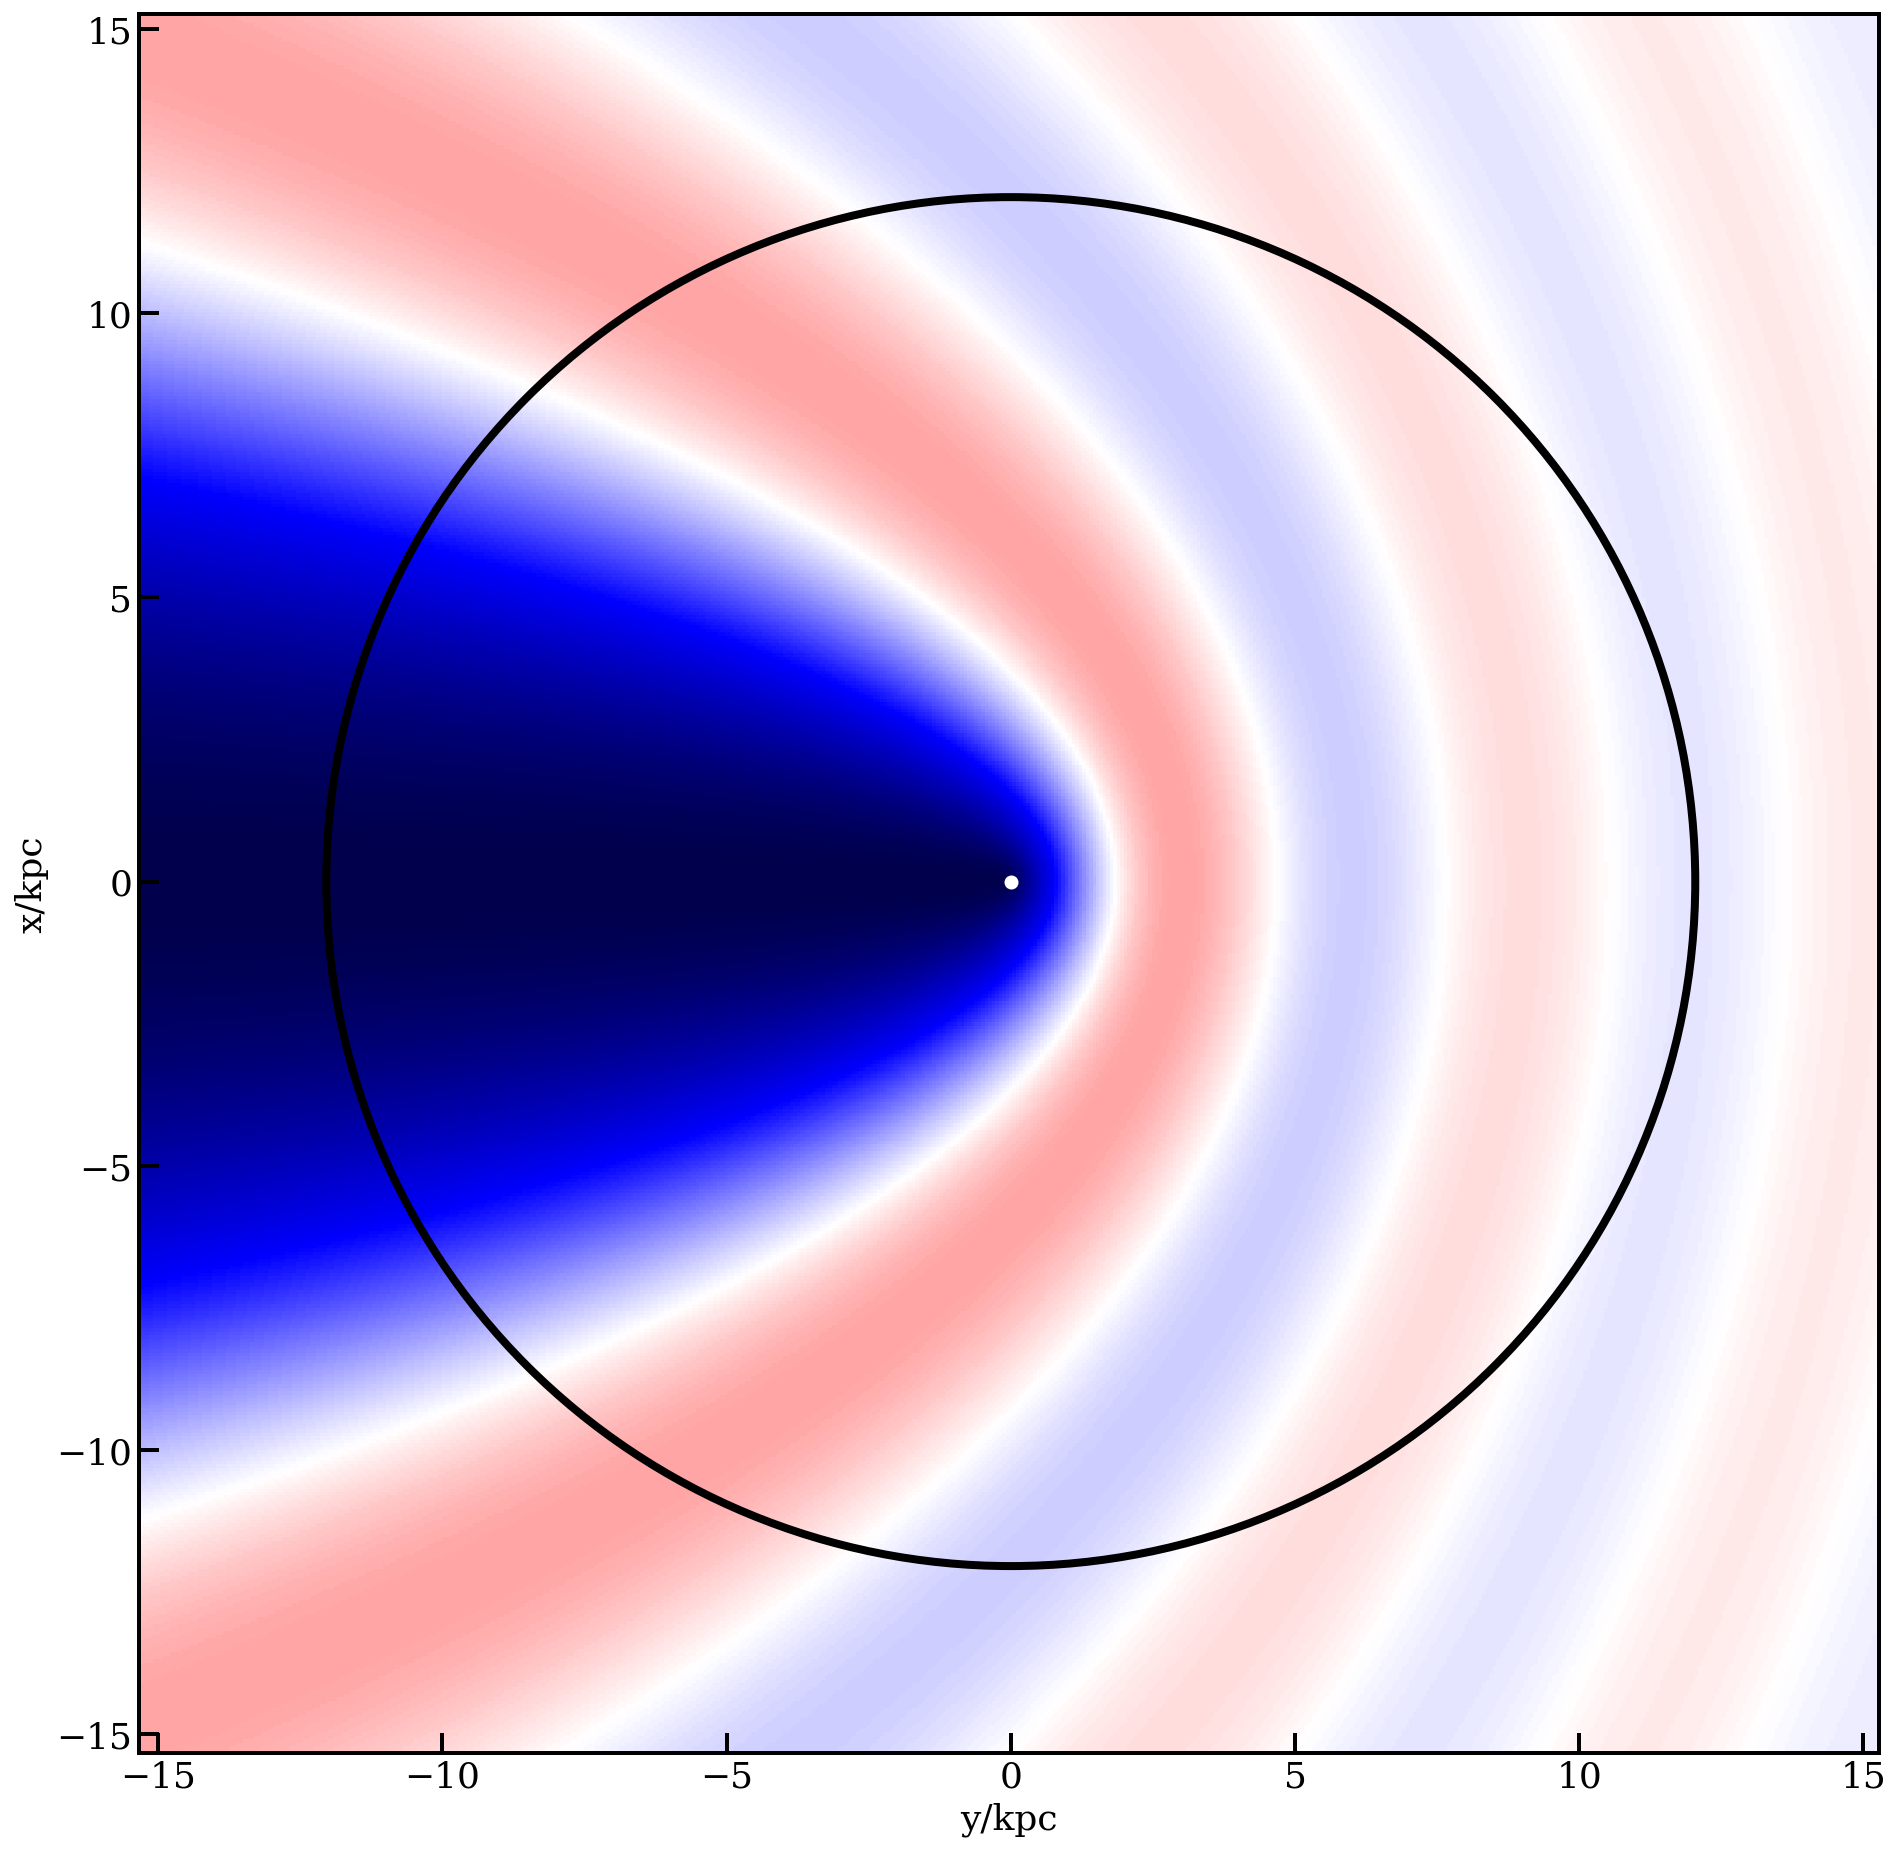

In [833]:
Hypr = np.log10(np.abs(Hyp))

fig, ax = plt.subplots(figsize = (16,16),dpi = 144)

plt.imshow((Hypr),
           origin = 'lower',
          cmap = DivPalette,
          extent = (GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi,GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi),
          vmin = -np.max(Hypr),
          vmax = np.max(Hypr))

circle = plt.Circle((0, 0), lambKpc, clip_on=True,fill = False,color = 'black',lw = 4)

ax.add_patch(circle)

ax.scatter([0],[0],color = 'white')

ax.tick_params(direction="in",length = 10)

ax.tick_params(color = 'k',width = 2)

plt.xlabel('y/kpc')
plt.ylabel('x/kpc')


plt.xlim(GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi)
plt.ylim(GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi)

plt.show()

10000.0


(-15.334199073754563, 15.272862277459545)

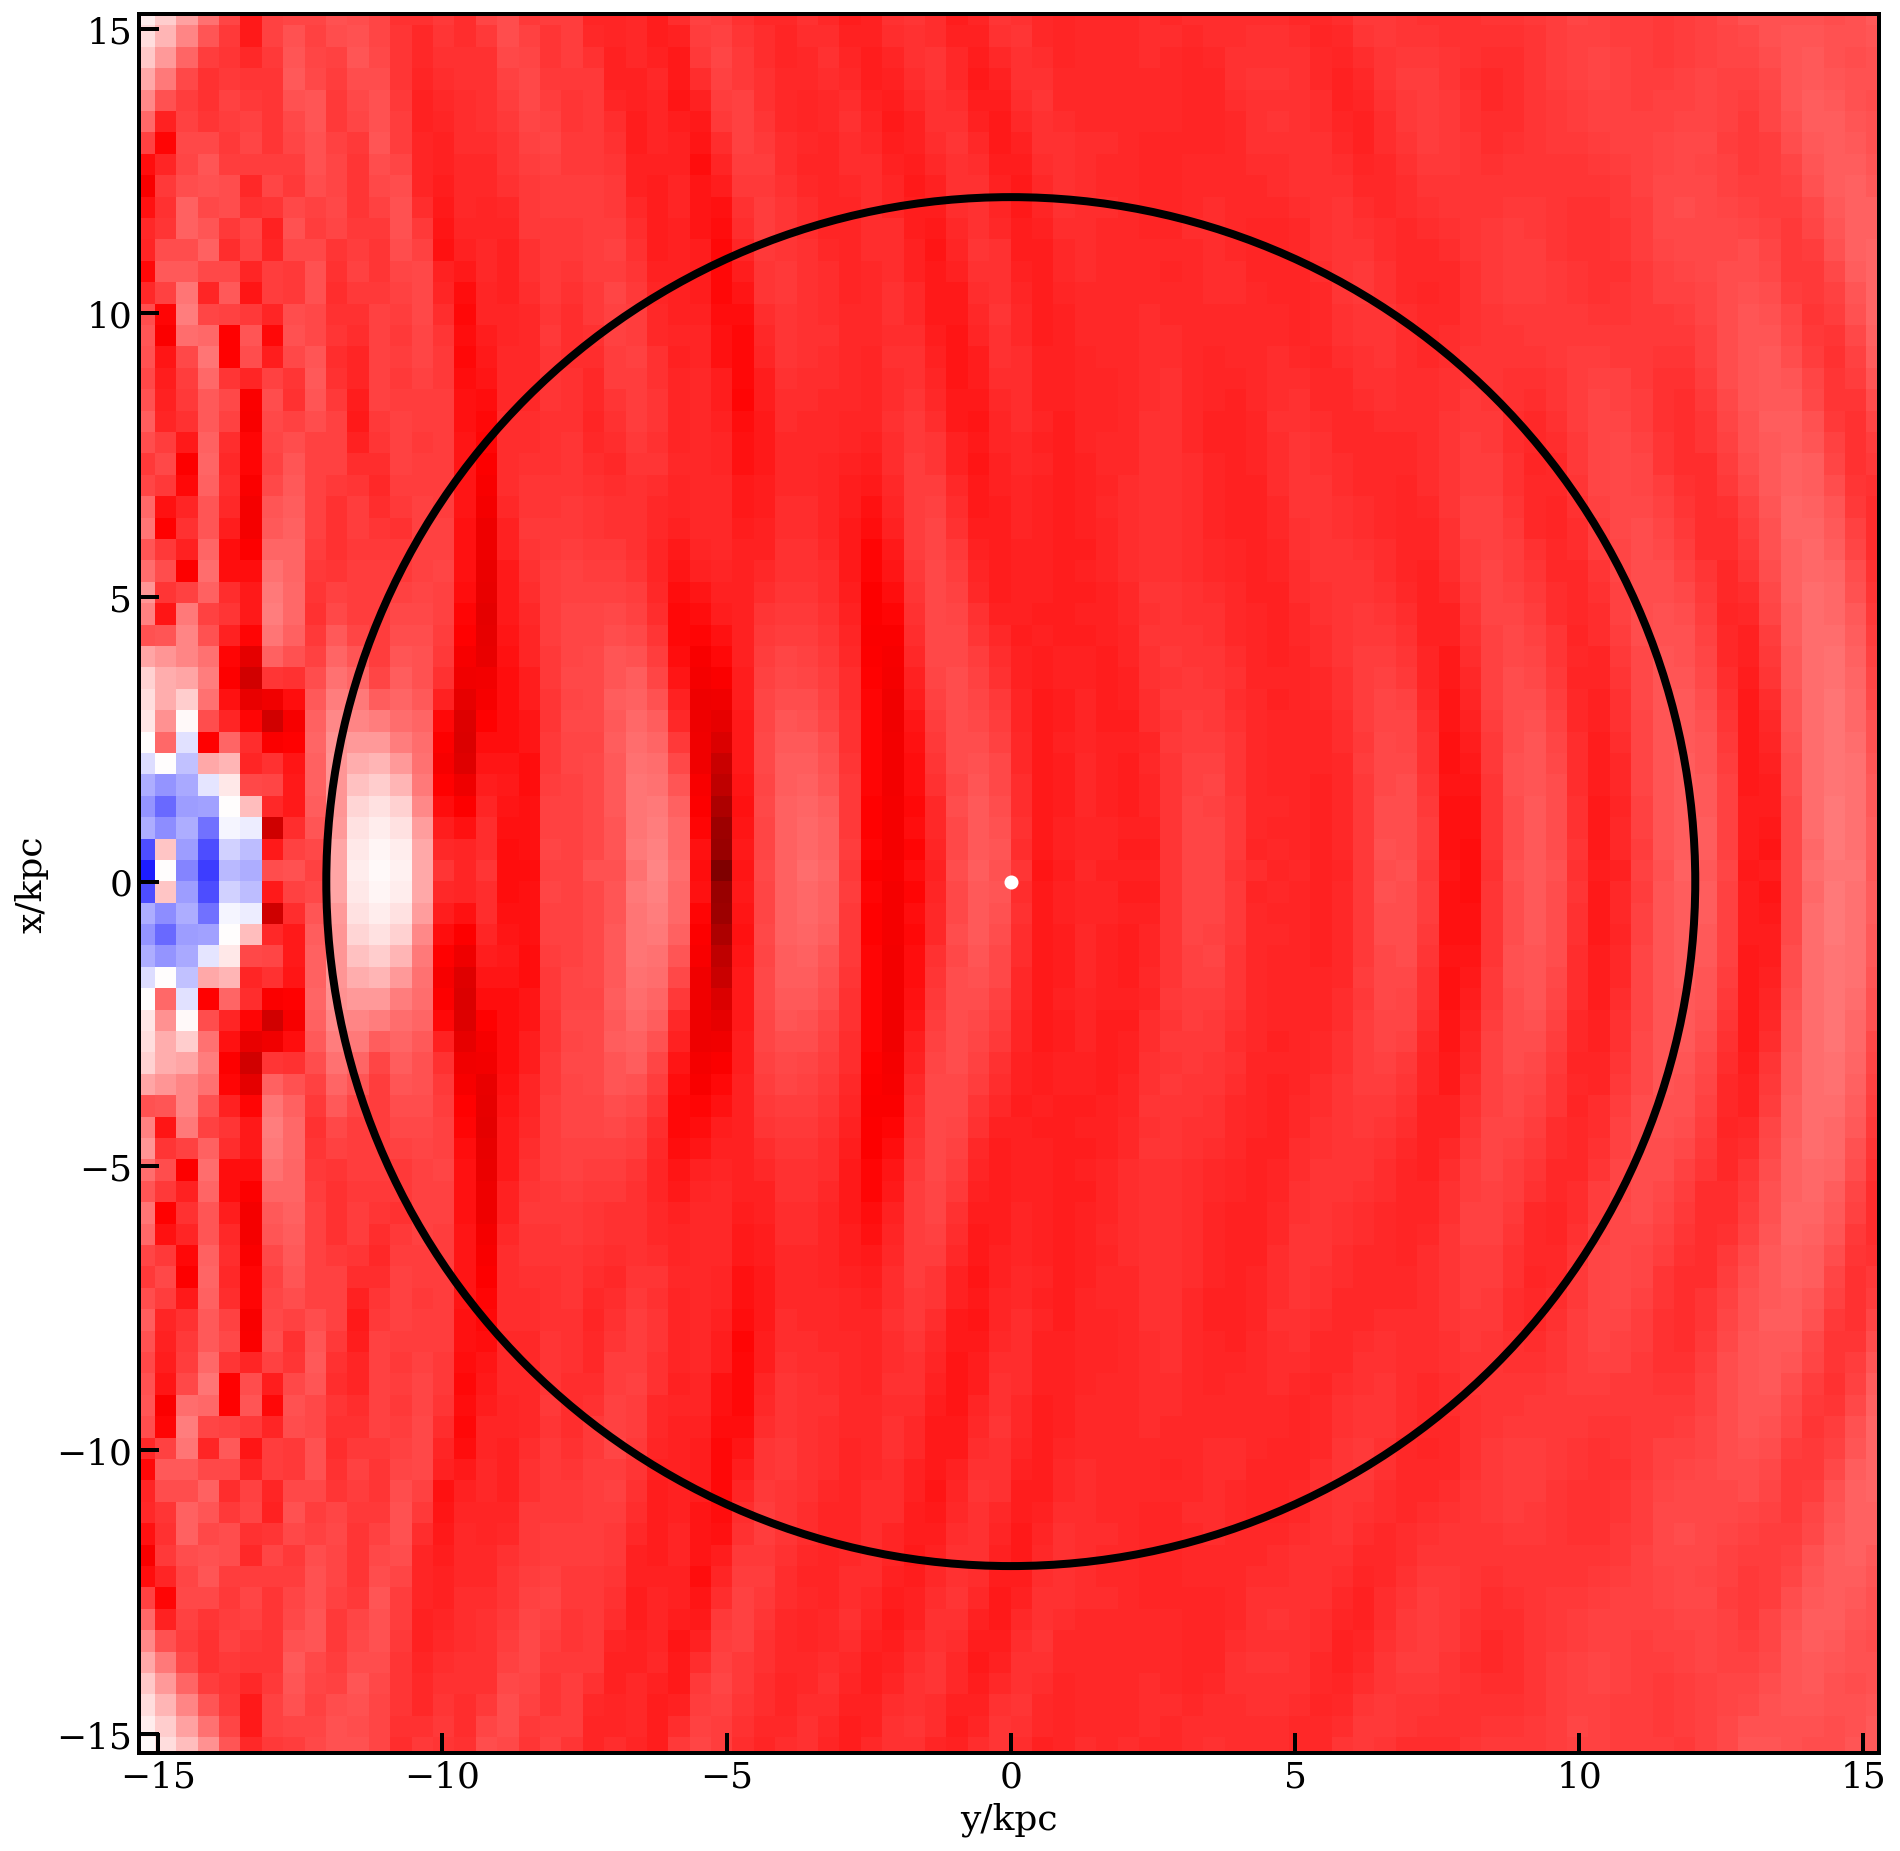

In [836]:
PsiR = np.log10(data[-50]/Density)

print(Density)

fig, ax = plt.subplots(figsize = (16,16),dpi = 144)

#image = plt.imshow(PsiR,extent = (-bound/2-TML,bound/2-TML,-bound/2,bound/2))

circle = plt.Circle((0, 0), lambKpc, clip_on=True,fill = False,color = 'black',lw = 4)
ax.scatter([0],[0],color = 'white')
ax.add_patch(circle)


plt.imshow((PsiR),
           origin = 'lower',
          cmap = DivPalette,
          extent = (-bound/2-TML,bound/2-TML,-bound/2,bound/2))

ax.tick_params(direction="in",length = 10)

ax.tick_params(color = 'k',width = 2)


plt.xlabel('y/kpc')
plt.ylabel('x/kpc')

plt.xlim(GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi)
plt.ylim(GridVec[0]/2/np.pi,GridVec[-1]/2/np.pi)

#cb = plt.colorbar(orientation = 'horizontal',ticks = [-0.0002,0,0.0002])
#cb.ax.set_xticklabels(['Underdensity','Background','Overdensity'])
#cb.ax.tick_params(direction="in",length = 0)


In [837]:
resol

256

In [838]:
duration

5000

0 0


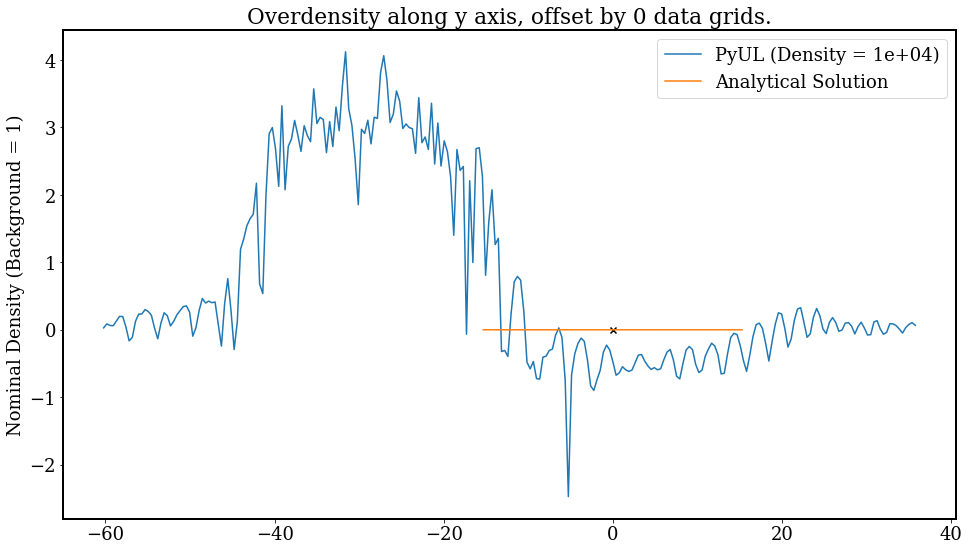

In [839]:
Offset = 0

OffsetH = int(Offset*resolA*np.pi/resol)


fig, ax = plt.subplots(figsize = (16,9))

fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

ax.set_title(f'Overdensity along y axis, offset by {Offset} data grids.')
ax.set_ylabel('Nominal Density (Background = 1)')



print(Offset,OffsetH)

ax.plot(GridVecR-TML,PsiR[resol//2+Offset,:],'-',label = f'PyUL (Density = {Density:.3g})')
ax.plot(GridVec/2/np.pi,Hypr[resolA//2+OffsetH,:],'-', label = 'Analytical Solution')



ax.scatter([0],[0],marker = 'x',color = 'k')
ax.legend()


001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591600

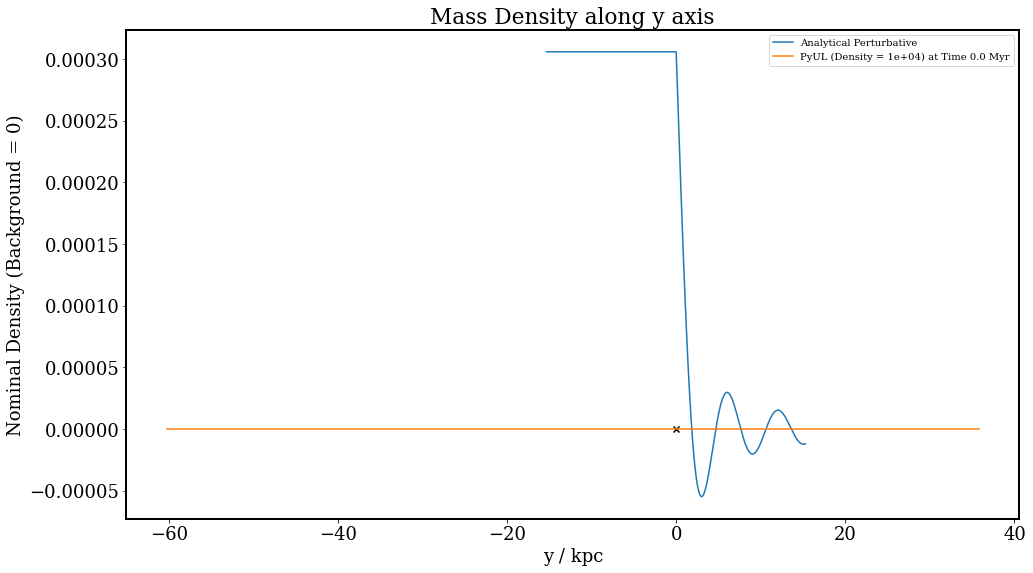

In [842]:
fig, ax = plt.subplots(figsize = (16,9),dpi = 72)


timerange = np.linspace(0,durationMyr,save_number+1)

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * durationMyr / (save_number+1)



def animate(i):
    
    ax.cla()
    
    ax.set_title('Mass Density along y axis')
    ax.set_ylabel('Nominal Density (Background = 0)')

    ax.set_xlabel('y / kpc')


    ax.plot(GridVec/2/np.pi,Hypr[resolA//2,:],'-', label = 'Analytical Perturbative')
    
    PsiR = ((data[i])/Density)-1
    
    ax.plot(GridVecR-TML,PsiR[resol//2,:],'-',label = f'PyUL (Density = {Density:.3g}) at Time {Tp[i]:.1f} Myr')
    
    ax.scatter([0],[0],marker = 'x',color = 'k')
    
    
    print(f'{i}',end = '')
    
    ax.legend(prop={"size":10})
   

aniDC = matplotlib.animation.FuncAnimation(fig,animate,EndNum,interval=0.01,blit=False)

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=15, metadata=dict(artist='PyUltraLightF'))

aniDC.save('2.mp4', writer=writer)
